In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
from client import Client
from server import Server
from model import MLP
from utils import utils as uu
import random

In [ ]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'You are using device: {device}')

In [3]:
dataset_dir: Path = Path("femnist")
centralized_partition: Path = dataset_dir / 'client_data_mappings' / 'centralized'
partition_dir = dataset_dir / 'client_data_mappings' / 'fed_natural'

In [4]:
alphas = [1.0, 2.0, 3.0, 4.0, 5.0]
model_types = []
for alpha in alphas:
    if alpha > 1.0:
        model_types.append('Powerprop:(alpha={})'.format(alpha))
    else:
        model_types.append('Baseline')
print(model_types)

['Baseline', 'Powerprop:(alpha=2.0)', 'Powerprop:(alpha=3.0)', 'Powerprop:(alpha=4.0)', 'Powerprop:(alpha=5.0)']


## Start experiments with Server(2,5,5)

In [5]:
import os
import random

c_per_r = 5
rounds = 2
cids = [cid for cid in os.listdir("femnist/client_data_mappings/fed_natural") if "_" not in cid]
cids = random.choices(cids,k=c_per_r*rounds)
print(cids)

['1349', '1456', '673', '2054', '2292', '2362', '1701', '612', '157', '1729']


In [ ]:
acc_list = []
loss_list = []
weight_list = []
p_acc_list = []
p_loss_list = []

for alpha in alphas:
    print("===========================================================")
    print(f'Alpha={alpha}')
    s = Server(c_per_r, rounds, device, cids=cids, client_epoch=5, alpha=alpha)
    acc,loss,ws,pacc,ploss = s.process()
    acc_list.append(acc)
    loss_list.append(loss)
    weight_list.append(ws)
    p_acc_list.append(pacc)
    p_loss_list.append(ploss)

## Save the results

In [ ]:
print(len(weight_list))
print(len(weight_list[0]))
print(len(weight_list[0][0]))
print(weight_list[0][0][0].shape)

weights = []
for i in range(len(weight_list)):
    weight1 = []
    for j in range(len(weight_list[i])):
        layers = []
        for layer in weight_list[i][j]:
            layers.append(layer.to("cpu"))
        weight1.append(layers)
    weights.append(weight1)

print(len(weights))
print(len(weights[0]))
print(len(weights[0][0]))
print(weights[0][0][0].shape)

np.save(r'./results/s_5_2_5/weight_list.npy', np.array(weights))

In [14]:
np.save(r'./results/s_5_2_5/acc_list.npy', np.array(acc_list))
np.save(r'./results/s_5_2_5/loss_list.npy', np.array(loss_list))
#np.save(r'./results/s_2_5_20/weight_list.npy', np.array(weight_list))
np.save(r'./results/s_5_2_5/p_acc_list.npy', np.array(p_acc_list))
np.save(r'./results/s_5_2_5/p_loss_list.npy', np.array(p_loss_list))

## Plot the results

In [15]:
import seaborn as sns

### Pruned accuracy

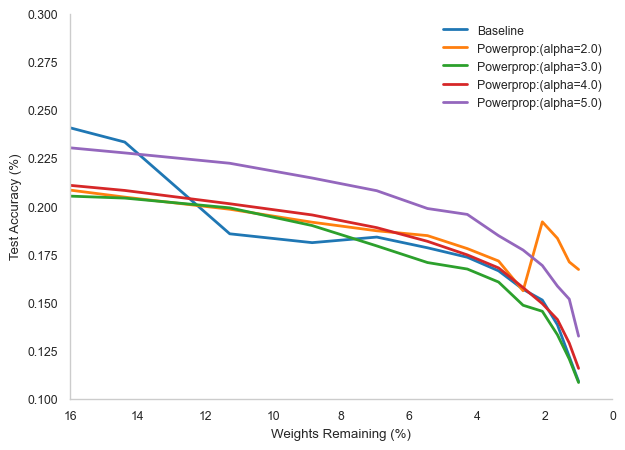

In [20]:
# adjust the data
new_means = np.load('./results/s_5_2_5/p_acc_list.npy')

sns.set_style("whitegrid")
sns.set_context("paper")

sparsity_levels = 100 * np.geomspace(0.01, 1.0, 20)

f, ax = plt.subplots(1, 1, figsize=(7, 5))
for i, label in enumerate(model_types):
    ax.errorbar(sparsity_levels, new_means[i], label=label, lw=2)

ax.set_xlim([16, 0.0])
ax.set_ylim([0.1, 0.3])
ax.legend(frameon=False)
ax.grid(False)
ax.set_xlabel('Weights Remaining (%)')
ax.set_ylabel('Test Accuracy (%)')
sns.despine()
f.savefig('./images/s_5_2_5/pruned_acc_plot.png')

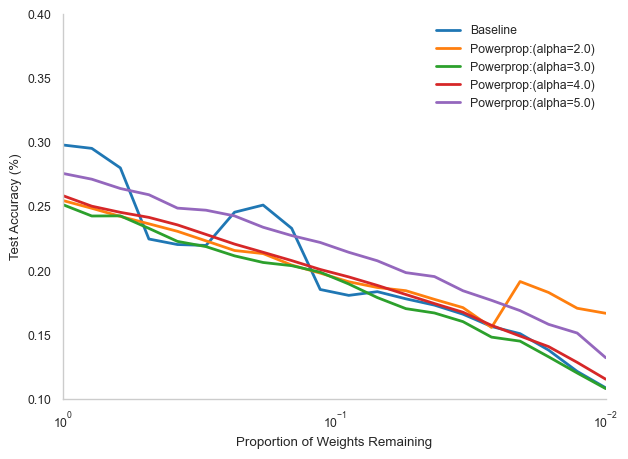

In [21]:
sns.set_style("whitegrid")
sns.set_context("paper")

sparsity_levels = np.geomspace(0.01, 1.0, 20)

f, ax = plt.subplots(1, 1, figsize=(7, 5))
for i, label in enumerate(model_types):
    ax.errorbar(sparsity_levels, new_means[i], label=label, lw=2)

ax.set_xscale('log')
ax.set_xlim([1.0, 0.01])
ax.set_ylim([0.1, 0.4])
ax.legend(frameon=False)
ax.grid(False)
ax.set_xlabel('Proportion of Weights Remaining')
ax.set_ylabel('Test Accuracy (%)')

sns.despine()
f.savefig('./images/s_5_2_5/pruned_acc_log_plot.png')

### Weight analysis

In [ ]:
weights = np.load('./results/s_5_2_5/weight_list.npy',allow_pickle=True)
weights.shape

In [ ]:
init_weights = weights[:,0,:]
final_weights = weights[:,-1,:]
print(init_weights.shape)
print(final_weights.shape)

In [ ]:
i = 4
initw,finalw = torch.flatten(init_weights[i][0]), torch.flatten(final_weights[i][0])
for fw, iw in zip(final_weights[i][1:], init_weights[i][1:]):
    initw = torch.hstack((initw,torch.flatten(iw)))
    finalw = torch.hstack((finalw,torch.flatten(fw)))
    print(initw.shape) 
    print(finalw.shape)
points = random.choices(list(zip(initw,finalw)),k=1000)

In [ ]:
points = np.array(points)
print(points.shape)
plt.scatter(points[:,0],points[:,1],)
plt.xlabel("Initial weight values")
plt.ylabel("Final weight values")
plt.savefig("images/s_5_2_5/weight_scatter_alpha"+str(i+1)+".png")
plt.show()
